In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")


**General IC network learning rule**

In [116]:
class RNN:
    def __init__(self, neurons_count: int):
        self.coupling_matrix: np.array = np.zeros((neurons_count, neurons_count))
        self.last_output: np.array = np.zeros(neurons_count)
        self.__identity_matrix: np.array = None
    
    def predict(self, external_input: np.array = None) -> np.array:
        raise NotImplementedError("Concrete RNN should implement this method")
    
    def train(self, train_sequences: np.array, learning_rate: float, 
              min_weights_change: float, iterations_max: int = 10000, verbose: bool = False):
        if verbose:
            print("Training is started")
            print("Sequences to learn {0}".format(training_sequences.shape[0]))
            for sequence_num, sequence in enumerate(train_sequences):
                print("> Sequence {0} has {1} sequences units".format(sequence_num + 1,
                                                                      sequence.shape[0]))
            print("Learning rate {0}".format(learning_rate))
            print("Minimum weights changes {0}".format(min_weights_change))
            print("Maximum iterations {0}".format(iterations_max))
        weights_change: float =  1.
        iterations_done: int = 0
        self.__identity_matrix = np.identity(len(self.coupling_matrix))
        coupling_matrix_update: np.array = self.coupling_matrix.copy()
        while weights_change > min_weights_change and iterations_done < iterations_max:
            coupling_matrix_update = self.__training_step(train_sequences, learning_rate, verbose)
            weights_change = np.linalg.norm(self.coupling_matrix - coupling_matrix_update)
            self.coupling_matrix = coupling_matrix_update.copy()
            iterations_done += 1
            if verbose:
                print("Training step {0} from {1} | Weights change {2}".format(iterations_done, 
                                                                               iterations_max,
                                                                               weights_change))
        if verbose:
            print("Training is finished")
        self.__identity_matrix = None
            
    def __training_step(self, train_sequences: np.array, learning_rate: float, 
                        verbose: bool = False) -> np.array:
        coupling_matrix = self.coupling_matrix.copy()
        for sequence in train_sequences:
            if len(sequence) == 1:
                coupling_matrix = self.__static_sequences_learning_rule(coupling_matrix,
                                                                        sequence[0], learning_rate)
            else:
                coupling_matrix = self.__dynamic_sequences_learning_rule(coupling_matrix,
                                                                         sequence, learning_rate)
        return coupling_matrix
    
    def __static_sequences_learning_rule(self, coupling_matrix: np.array, sequence_unit: np.array,
                                         learning_rate: float) -> np.array:
        correction = learning_rate * np.outer(sequence_unit, sequence_unit)
        return coupling_matrix.dot(self.__identity_matrix - correction) + correction
    
    def __dynamic_sequences_learning_rule(self, coupling_matrix: np.array, sequence: np.array,
                                          learning_rate: float) -> np.array:
        previous_sequence_unit = sequence[0]
        for sequence_unit in sequence[1:]:
            delay_correction = learning_rate * np.outer(previous_sequence_unit, previous_sequence_unit)
            correction = learning_rate * np.outer(sequence_unit, previous_sequence_unit)
            coupling_matrix = coupling_matrix.dot(self.__identity_matrix - delay_correction) + correction
            previous_sequence_unit = sequence_unit
        return coupling_matrix

**IC network units**

In [117]:
class SuRNN(RNN):
    def __init__(self, neurons_count: int):
        super().__init__(neurons_count)
    
    def predict(self, external_input: np.array = None) -> np.array:
        if external_input is None:
            self.last_output = self.coupling_matrix.dot(self.last_output)
        else:
            assert len(external_input) == len(self.coupling_matrix), "External input shape mismatch"
            self.last_output = external_input
        return self.last_output
    

class MuRNN(RNN):
    def __init__(self, neurons_count: int):
        super().__init__(neurons_count)
    
    def predict(self, external_input: np.array = None) -> np.array:
        if self.external_input is None:
            self.last_output = self.coupling_matrix.dot(self.last_output)
        else:
            assert len(external_input) == len(self.coupling_matrix), "External input shape mismatch"
            new_output = self.coupling_matrix.dot(self.last_output)
            if np.all(new_output >= 0):
                self.last_output = np.maximum(external_input, new_output)
            else:
                self._last_output = np.minimum(external_input, new_output)
        return self.last_output

**Su units tests**

SU network for static sequence 

In [118]:
suRNN = SuRNN(3)
training_sequence_unit = np.array([1., 3., 2.])
training_sequence = np.array([training_sequence_unit])
print("Sequence to learn {0}".format(training_sequence))
training_sequences = np.array([training_sequence])
suRNN.train(training_sequences, 0.08, 1e-7, 30, True)
print("Sequence prediction with external input {0}".format(suRNN.predict(training_sequence_unit)))
print("Sequence recurrent prediction")      
for i in range(4):
    print("Prediction {0} {1}".format(i + 1, suRNN.predict()))

Sequence to learn [[ 1.  3.  2.]]
Training is started
Sequences to learn 1
> Sequence 1 has 1 sequences units
Learning rate 0.08
Minimum weights changes 1e-07
Maximum iterations 30
Training step 1 from 30 | Weights change 1.1199999999999999
Training step 2 from 30 | Weights change 0.13439999999999996
Training step 3 from 30 | Weights change 0.016128000000000035
Training step 4 from 30 | Weights change 0.0019353600000000673
Training step 5 from 30 | Weights change 0.0002322431999999373
Training step 6 from 30 | Weights change 2.7869183999888548e-05
Training step 7 from 30 | Weights change 3.3443020800111696e-06
Training step 8 from 30 | Weights change 4.013162496584772e-07
Training step 9 from 30 | Weights change 4.815795000279177e-08
Training is finished
Sequence prediction with external input [ 1.  3.  2.]
Sequence recurrent prediction
Prediction 1 [ 1.00000001  3.00000002  2.00000001]
Prediction 2 [ 1.00000001  3.00000003  2.00000002]
Prediction 3 [ 1.00000002  3.00000005  2.00000003

SU network for 2 vectors

In [119]:
suRNN = SuRNN(3)
training_sequence = np.array([[1., 3., 2.], [1., 1., 1.], [1., 3., 2.]])
print("Sequence to learn {0}".format(training_sequence))
training_sequences = np.array([training_sequence])
suRNN.train(training_sequences, 0.35, 1e-7, 40, verbose=True)
print("Sequence prediction with external input {0}".format(suRNN.predict(np.array([1., 1., 1.]))))
print("Sequence recurrent prediction")      
for i in range(10):
    print("Prediction {0} {1}".format(i + 1, suRNN.predict()))

Sequence to learn [[ 1.  3.  2.]
 [ 1.  1.  1.]
 [ 1.  3.  2.]]
Training is started
Sequences to learn 1
> Sequence 1 has 3 sequences units
Learning rate 0.35
Minimum weights changes 1e-07
Maximum iterations 40
Training step 1 from 40 | Weights change 2.3345288603913206
Training step 2 from 40 | Weights change 3.513084512219994
Training step 3 from 40 | Weights change 1.7730391898909044
Training step 4 from 40 | Weights change 0.22944684842944016
Training step 5 from 40 | Weights change 0.28672372829263215
Training step 6 from 40 | Weights change 0.15653812517657434
Training step 7 from 40 | Weights change 0.02304379594548279
Training step 8 from 40 | Weights change 0.023217996963705297
Training step 9 from 40 | Weights change 0.013745006980052536
Training step 10 from 40 | Weights change 0.002308374490852991
Training step 11 from 40 | Weights change 0.0018638884875009792
Training step 12 from 40 | Weights change 0.001200532359223002
Training step 13 from 40 | Weights change 0.00022845

SU network for 3 vectors

In [120]:
suRNN = SuRNN(3)
training_sequence = np.array([[1., 3., 2.], [1., 1., 1.], [-1., 2., 0.], [1., 3., 2.]])
print("Sequence to learn {0}".format(training_sequence))
training_sequences = np.array([training_sequence])
suRNN.train(training_sequences, learning_rate=0.35, min_weights_change=1e-8,
            iterations_max=300, verbose=True)
print("Sequence prediction with external input {0}".format(suRNN.predict(np.array([1., 1., 1.]))))
print("Sequence recurrent prediction")      
for i in range(10):
    print("Prediction {0} {1}".format(i + 1, suRNN.predict()))

Sequence to learn [[ 1.  3.  2.]
 [ 1.  1.  1.]
 [-1.  2.  0.]
 [ 1.  3.  2.]]
Training is started
Sequences to learn 1
> Sequence 1 has 4 sequences units
Learning rate 0.35
Minimum weights changes 1e-08
Maximum iterations 300
Training step 1 from 300 | Weights change 2.565702328310905
Training step 2 from 300 | Weights change 1.9320749061256315
Training step 3 from 300 | Weights change 1.7798980344519248
Training step 4 from 300 | Weights change 1.85603011268938
Training step 5 from 300 | Weights change 1.9621953049635696
Training step 6 from 300 | Weights change 2.046703591838263
Training step 7 from 300 | Weights change 2.082061468479767
Training step 8 from 300 | Weights change 2.0612318604884483
Training step 9 from 300 | Weights change 1.9870415595210202
Training step 10 from 300 | Weights change 1.8672126040681933
Training step 11 from 300 | Weights change 1.711679941555484
Training step 12 from 300 | Weights change 1.5310880877146726
Training step 13 from 300 | Weights change 1

**Trajectories prediction**

Trajectories generation

In [121]:
import sys

def compute_trajectory(position: np.array, speed: np.array, acceleration: np.array,
                       time: np.array) -> list:
    return [np.array([position + speed*t + 0.5*acceleration*(t**2), speed + acceleration*t, acceleration]) for t in time]


def generate_random_initial_position(space_constraints: list) -> np.array:
    position: list = list()
    for constrains in space_constraints:
        min_coordinate, max_coordinate = constrains
        position.append(np.random.rand()*(max_coordinate - min_coordinate) + min_coordinate)
    return np.array(position)


def generate_random_vector_with_given_max_amplitude(dimension: int, max_amplitude: float) -> \
        np.array:
    random_direction = np.random.rand(dimension)*2 - 1
    random_direction /= np.linalg.norm(random_direction)
    random_amplitude = np.random.rand()*max_amplitude
    return random_amplitude*random_direction


def generate_random_speed(dimension: int, max_speed: float) -> np.array:
    return generate_random_vector_with_given_max_amplitude(dimension, max_speed)


def generate_random_acceleration(dimension: int, max_acceleration: float) -> np.array:
    return generate_random_vector_with_given_max_amplitude(dimension, max_acceleration)


def generate_trajectories_dataset(trajectories_count, space_constraints, max_speed, max_acceleration, time) -> np.array:
    space_dimension: int = len(space_constraints)
    trajectories_dataset = []
    for trajectory_num in range(trajectories_count):
        sys.stdout.write("\rGenerating trajectory {0} out from {1}".format(trajectory_num + 1, trajectories_count))
        initial_position: np.array = generate_random_initial_position(space_constraints)
        initial_speed: np.array = generate_random_speed(space_dimension, max_speed)
        acceleration: np.array = generate_random_acceleration(space_dimension, max_acceleration)
        dataset_entry = compute_trajectory(initial_position, initial_speed, acceleration, time)
        trajectories_dataset.append(dataset_entry)
    print("\nTrajectories generation done!")
    return np.array(trajectories_dataset)

In [122]:
trajectories_count = 60
space_constrains = [[0., 10.],
                   [0., 10.]]
max_speed = 2.5
max_acceleration = 1.
time = np.linspace(0., 2., 200)
training_trajectories = generate_trajectories_dataset(trajectories_count, space_constrains, max_speed,
                                            max_acceleration, time)
training_set = training_trajectories.reshape((trajectories_count, len(time), 6))

Generating trajectory 60 out from 60
Trajectories generation done!


In [292]:
print(training_trajectories.shape)
training_set  = training_trajectories.reshape((300, 200, 6))
print(training_set[0, 0])

(300, 200, 3, 2)
[ 6.22582322  7.41968742 -1.75989986 -1.56337538  0.40364027  0.12354403]


In [124]:
tmrnn = SuRNN(6)
tmrnn.train(training_set, learning_rate=0.001, min_weights_change=1e-8,
            iterations_max=100, verbose=True)
print(tmrnn.coupling_matrix)

Training is started
Sequences to learn 1
> Sequence 1 has 200 sequences units
> Sequence 2 has 200 sequences units
> Sequence 3 has 200 sequences units
> Sequence 4 has 200 sequences units
> Sequence 5 has 200 sequences units
> Sequence 6 has 200 sequences units
> Sequence 7 has 200 sequences units
> Sequence 8 has 200 sequences units
> Sequence 9 has 200 sequences units
> Sequence 10 has 200 sequences units
> Sequence 11 has 200 sequences units
> Sequence 12 has 200 sequences units
> Sequence 13 has 200 sequences units
> Sequence 14 has 200 sequences units
> Sequence 15 has 200 sequences units
> Sequence 16 has 200 sequences units
> Sequence 17 has 200 sequences units
> Sequence 18 has 200 sequences units
> Sequence 19 has 200 sequences units
> Sequence 20 has 200 sequences units
> Sequence 21 has 200 sequences units
> Sequence 22 has 200 sequences units
> Sequence 23 has 200 sequences units
> Sequence 24 has 200 sequences units
> Sequence 25 has 200 sequences units
> Sequence 26 has 

Generating trajectory 100 out from 100
Trajectories generation done!


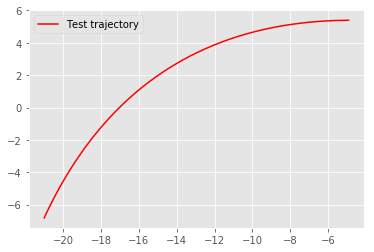

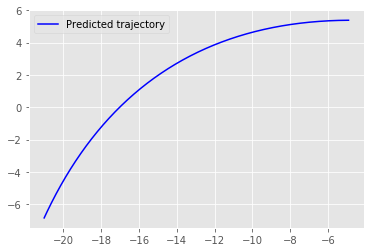

Mean predicted trajectory difference: 0.3901295360842486


In [129]:
test_trajectories = generate_trajectories_dataset(100, [[-10., 10.], [-10., 10.]], 10., 4., np.linspace(0, 3., 300))
test_trajectories = test_trajectories.reshape(100, 300, 6)
test_trajectory = test_trajectories[0]
plt.plot(test_trajectory[:, 0], test_trajectory[:, 1], 'r', label="Test trajectory")
plt.legend()
plt.show()
predicted_trajectory = []
predicted_point = tmrnn.predict(test_trajectory[0])
for i in range(len(test_trajectory)):
    predicted_trajectory.append(predicted_point)
    predicted_point = tmrnn.predict()
predicted_trajectory = np.array(predicted_trajectory)
plt.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'b', label="Predicted trajectory")
plt.legend()
plt.show()
trajectory_difference = 0.
for trajectory in test_trajectories:
    predicted_trajectory = []
    predicted_point = tmrnn.predict(trajectory[0])
    for i in range(len(trajectory)):
        predicted_trajectory.append(predicted_point)
        predicted_point = tmrnn.predict()
    predicted_trajectory = np.array(predicted_trajectory)
    trajectory_difference += np.linalg.norm(trajectory - predicted_trajectory)
print("Mean predicted trajectory difference: {0}".format(trajectory_difference / len(test_trajectories)))

**Compact internal representation of complex environments**

In [132]:
def rk4(function, initial_point: np.array, function_args: dict, 
        time_step: float, end_time: float, yield_every_step: bool = False) -> np.array:
    time_space = np.arange(0., end_time + time_step, time_step)
    solution = initial_point.copy()
    for time_point in time_space:
        k1 = function(time_point, solution, function_args)
        k2 = function(time_point, solution + 0.5*time_step*k1, function_args)
        k3 = function(time_point, solution + 0.5*time_step*k2, function_args)
        k4 = function(time_point, solution + time_step*k3, function_args)
        solution += time_step * (k1 + 2.*k2 + 2.*k3 + k4) / 6.
        if yield_every_step:
            yield solution
    return solution

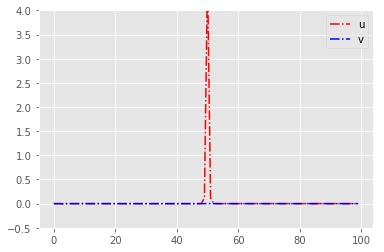

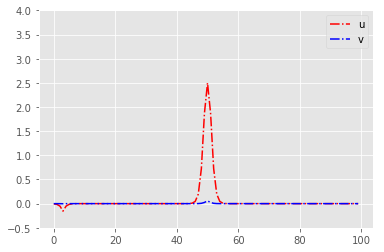

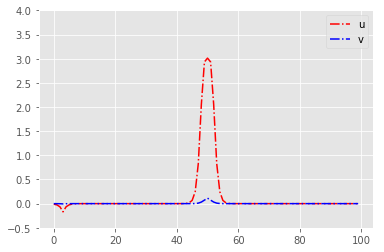

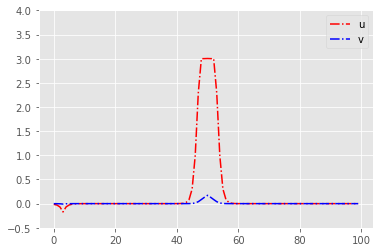

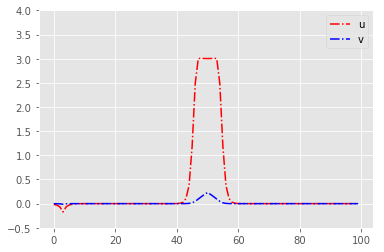

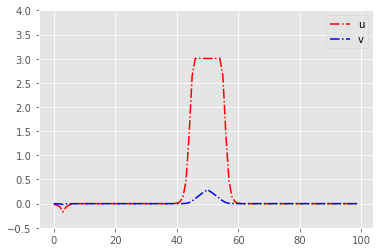

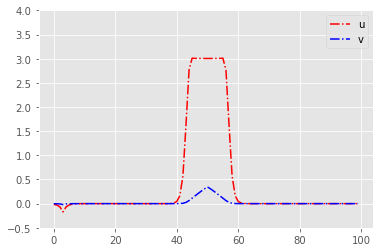

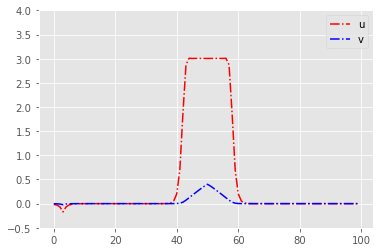

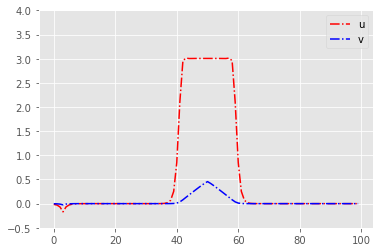

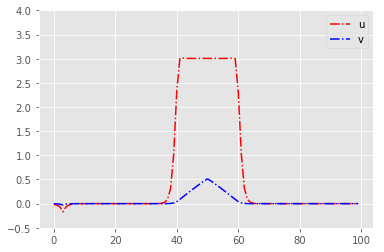

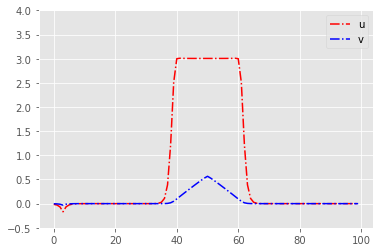

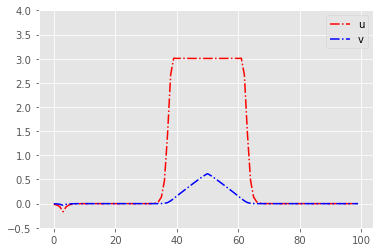

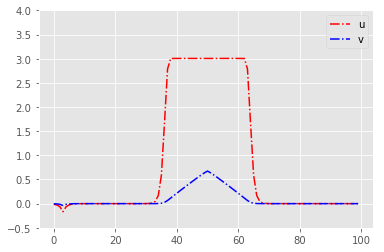

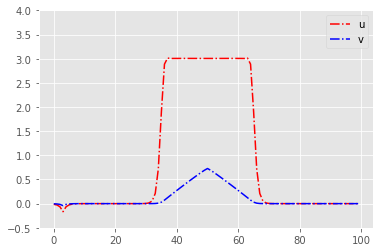

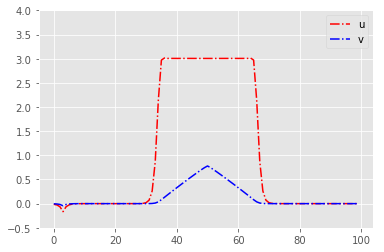

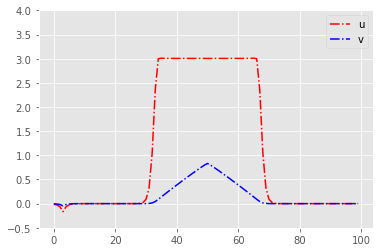

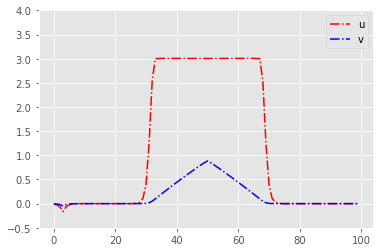

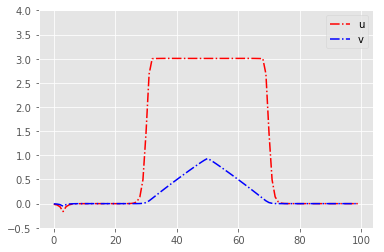

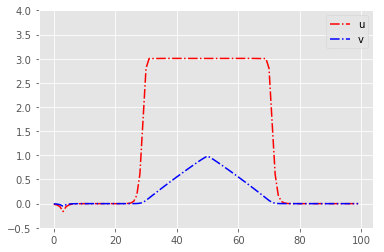

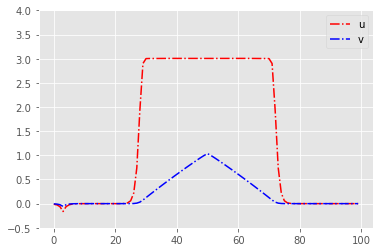

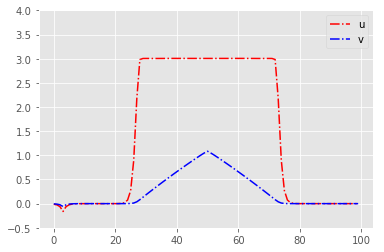

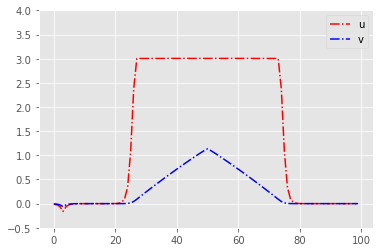

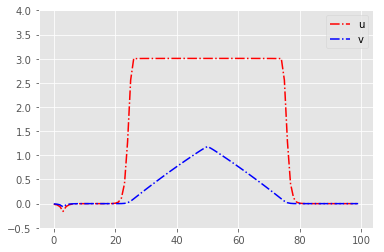

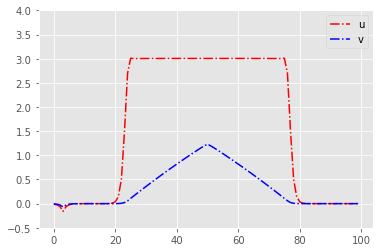

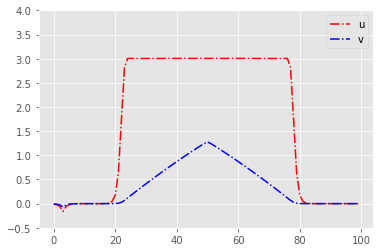

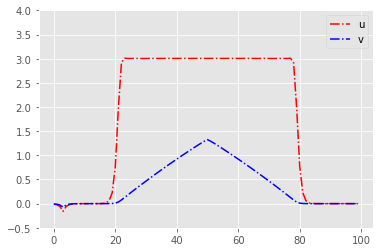

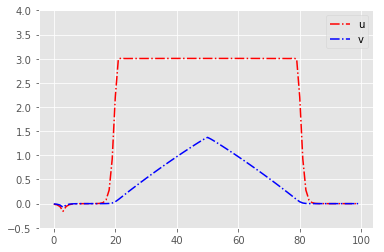

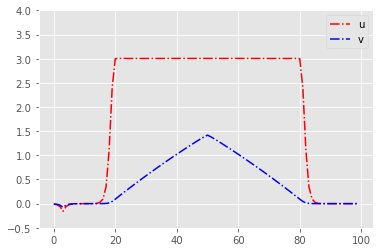

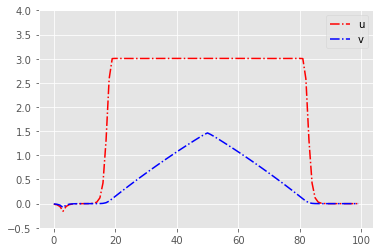

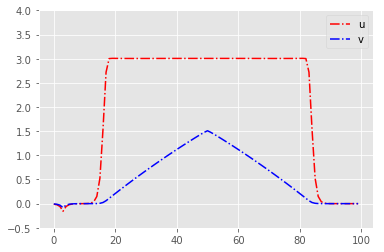

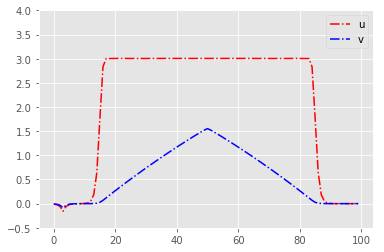

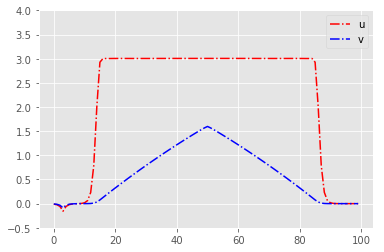

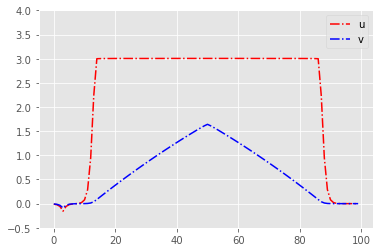

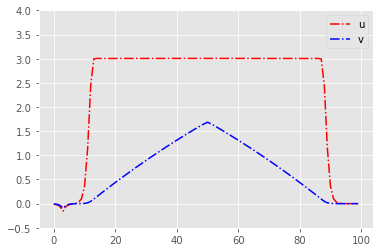

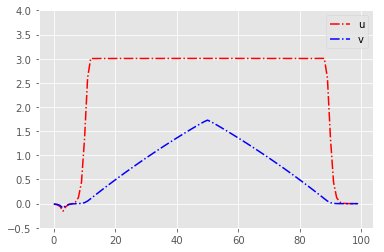

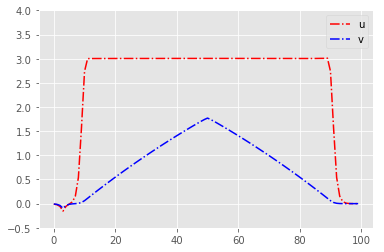

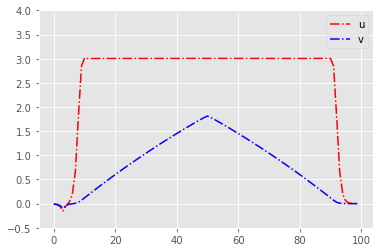

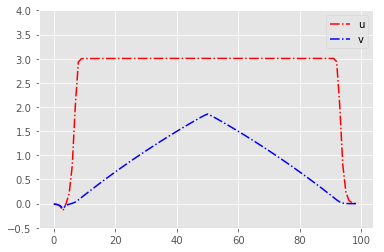

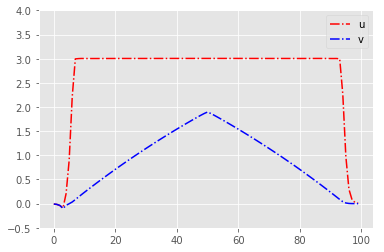

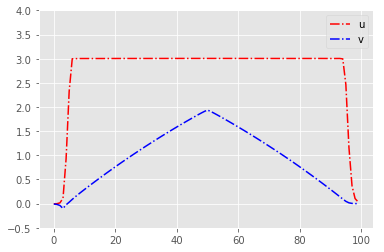

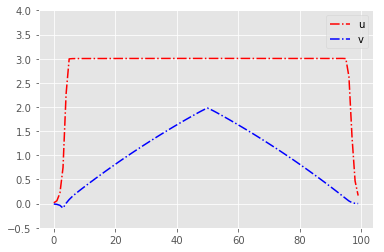

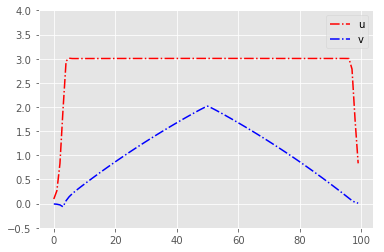

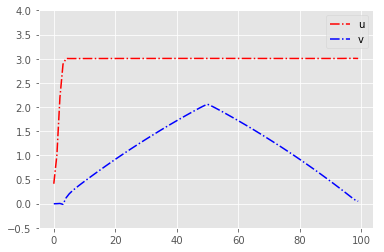

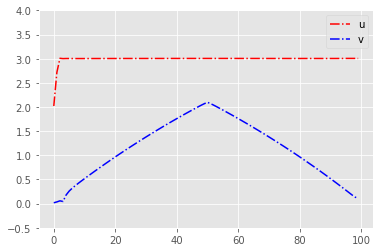

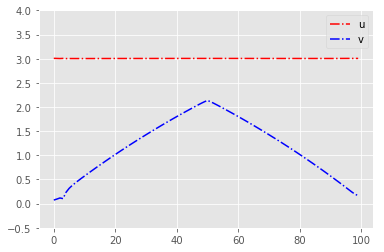

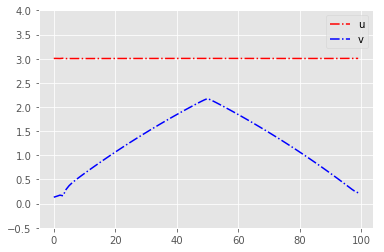

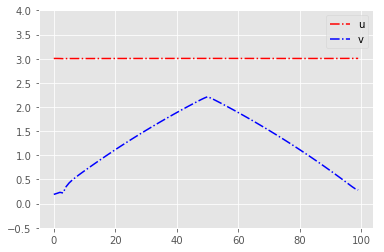

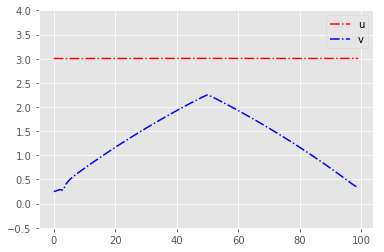

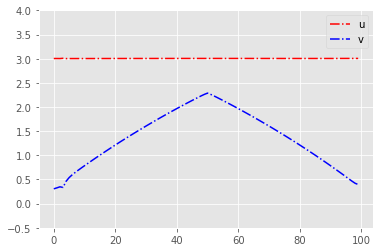

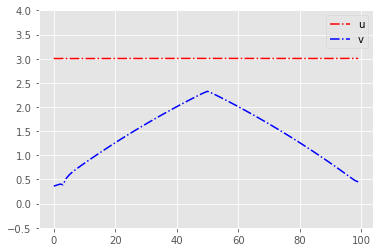

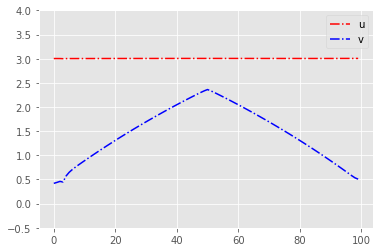

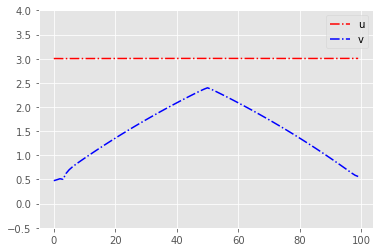

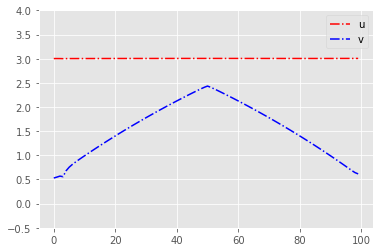

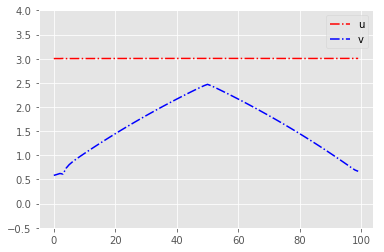

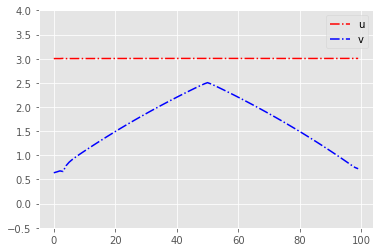

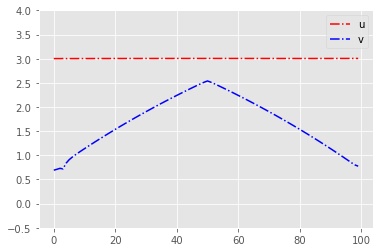

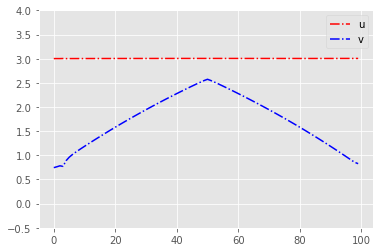

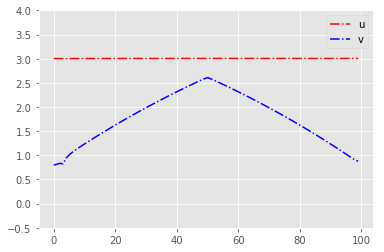

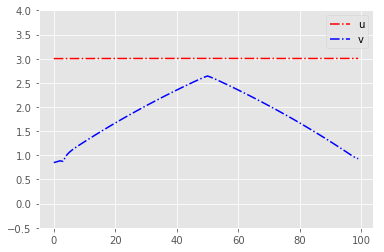

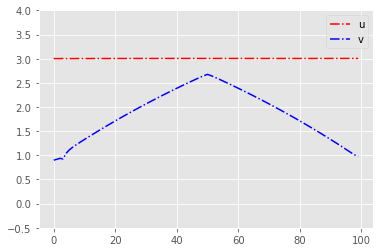

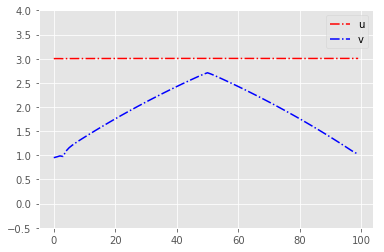

In [137]:
def target_influence(element_index: int) -> float:
    if element_index is 3:
        return 1.
    else:
        return 0.

def fhn_1d(time_point: float, X: np.array, function_args: dict) -> np.array:
    def left_bound_condition(element_index: int):
        if element_index == 0:
            return X[0, element_index]
        else:
            return X[0, element_index - 1]
        
    def right_bound_coundition(element_index: int):
        if element_index == X[0].shape[0] - 1:
            return X[0, element_index]
        else:
            return X[0, element_index + 1]

    new_X = np.zeros(X.shape)
    coupling = function_args.get("coupling")
    regime_threshold = function_args.get("regime_threshold")
    target_influence = function_args.get("target_influence")
    eps = function_args.get("eps")
    k = function_args.get("k")
    for i in range(X[0].shape[0]):
        left = left_bound_condition(i)
        right = right_bound_coundition(i)
        dX = coupling * (left + right - 2 * X[0, i])
        nonlinearity = (-X[0, i]**3 + 4.*X[0, i]**2 - 2*X[0, i])
        heaviside = X[0, i] <= regime_threshold
        new_X[0, i] = dX + heaviside * (nonlinearity - X[1, i]) - target_influence(i)
        new_X[1, i] = eps * (X[0, i] - k*X[1, i])
    return new_X

u = np.zeros(100, dtype=np.double)
u[50] = 5.
v = np.zeros(100, dtype=np.double)
args = {"coupling": 2.5, "regime_threshold": 3., "target_influence": target_influence,
       "eps": 0.04, "k": 0.5}
initial_x = np.array([u, v])
for solution_num, solution in enumerate(rk4(fhn_1d, initial_x, args, 0.01, 30., True)):
    if solution_num % 50 ==0:
        plt.ylim(-0.5, 4)
        plt.plot(list(range(100)), solution[0], 'r-.', label='u')
        plt.plot(list(range(100)), solution[1], 'b-.', label='v')
        plt.legend()
        plt.show()

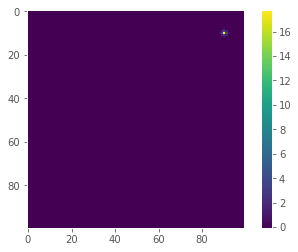

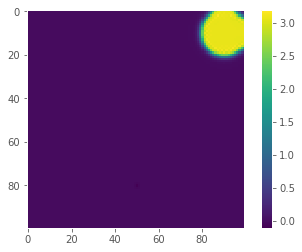

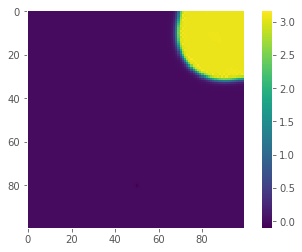

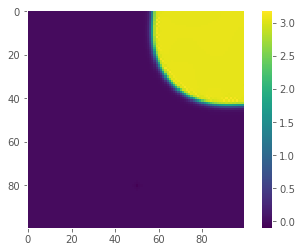

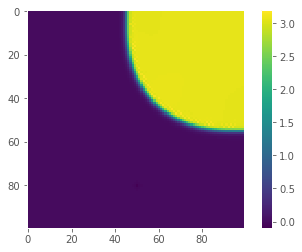

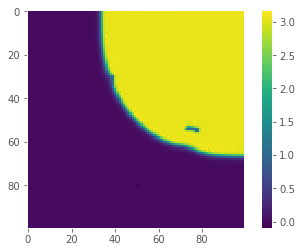

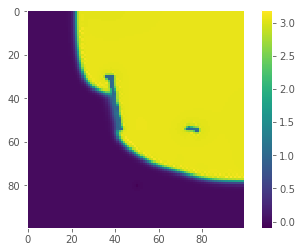

In [145]:
def target_influence(element_y: int, element_x: int) -> float:
    if element_x is 50 and element_y is 80:
        return 1.
    else:
        return 0.

def cnn(time_point: float, X: np.array, function_args: dict) -> np.array:
    def left_bound_condition(element_y: int, element_x: int) -> float:
        if element_x == 0:
            return X[0, element_y, element_x]
        else:
            return X[0, element_y, element_x - 1]
        
    def right_bound_coundition(element_y: int, element_x: int) -> float:
        if element_x == X[0].shape[0] - 1:
            return X[0, element_y, element_x]
        else:
            return X[0, element_y, element_x + 1]
        
    def top_bound_condition(element_y: int, element_x: int) -> float:
        if element_y == 0:
            return X[0, element_y, element_x]
        else:
            return X[0, element_y - 1, element_x]
        
    def bottom_bound_condition(element_y: int, element_x: int) -> float:
        if element_y == X[0].shape[1] - 1:
            return X[0, element_y, element_x]
        else:
            return X[0, element_y + 1, element_x]
    
    new_X = np.zeros(X.shape)
    coupling = function_args.get("coupling")
    regime_threshold = function_args.get("regime_threshold")
    target_influence = function_args.get("target_influence")
    eps = function_args.get("eps")
    k = function_args.get("k")
    for i in range(X[0].shape[0]):
        for j in range(X[0].shape[1]):
            left = left_bound_condition(i, j)
            right = right_bound_coundition(i, j)
            top = top_bound_condition(i, j)
            bottom = bottom_bound_condition(i, j)
            dX = coupling * (left + right + top + bottom - 4 * X[0, i, j])
            nonlinearity = X[0, i, j] * (-X[0, i, j]**2 + 4.*X[0, i, j] - 2)
            heaviside = X[0, i, j] <= regime_threshold
            new_X[0, i, j] = q[i, j] * (dX + heaviside * (nonlinearity - X[1, i, j]) - target_influence(i, j))
            new_X[1, i, j] = eps * (X[0, i, j] - k*X[1, i, j])
    return new_X


u = np.zeros((100, 100), dtype=np.double)
u[10, 90] = 40.
v = np.zeros((100, 100), dtype=np.double)
q = np.ones((100, 100), dtype=int)
obstacle = np.array([[30, 10], [54, 14]])
obstacle2 = np.array([[95, 95], [99, 99]])
args = {"coupling": 2.5, "regime_threshold": 3., "target_influence": target_influence,
       "eps": 0.04, "k": 0.5}
initial_x = np.array([u, v])
for solution_num, solution in enumerate(rk4(cnn, initial_x, args, 0.1, 30., True)):
    if solution_num % 10 == 0:
        obstacle[:, 1] += 1
        obstacle2[:, 1] -= 1
    if solution_num % 5 == 0:
        obstacle2[:, 0] -= 1
    for i in range(obstacle[0, 0], obstacle[1, 0] + 1, 1):
        for j in range(obstacle[0, 1], obstacle[1, 1] + 1, 1):
            if 1. < solution[0, i, j] < 2.7: # wavefront
                q[i, j] = 0
    for i in range(obstacle2[0, 0], obstacle2[1, 0] + 1, 1):
        for j in range(obstacle2[0, 1], obstacle2[1, 1] + 1, 1):
            if 1. < solution[0, i, j] < 2.7: # wavefront
                q[i, j] = 0
    if solution_num % 50 == 0:
        plt.imshow(solution[0,])
        plt.grid()
        plt.colorbar()
        plt.show()